## Importing Libraries and Dependencies

In [5]:
# Ignoring Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data sources and analysis
import pandas as pd
from yahoo_fin import stock_info as si
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use("fivethirtyeight")
import seaborn as sns

# Portfolio Optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Get discrete allocation of each share per stock
# need to install this package by running the command through terminal            conda install -c conda-forge cvxopt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [6]:
## Reading the best performers from the Database
best_performers = pd.read_csv('best_performers.csv')
best_performers.head()

,Ticker,Returns Compared,Score
0,AAPL,6.63,97.285068
1,ABMD,9.40,98.868778
2,ACN,2.57,81.108597
3,ADBE,3.03,86.764706
4,ADP,2.14,73.755656


In [7]:
## Initializing the final_df DataFrame
final_df = pd.DataFrame(columns = ['Tickers', 'Latest_Price', 'Score', 'PE_Ratio','PEG_Ratio','SMA_150', 'SMA_200', '52_week_low', '52_week_high'])

In [8]:
# We have to drop the peg ratio from our conditions because it was missing for some of the tickers and was giving error
# We could have pulled the beta value and make a condition out of it but due ti limitation of time couldn'e do it
for ticker in best_performers['Ticker']:
    try:
        df = pd.read_csv(f'stock_data/{ticker}.csv', index_col = 0)
        moving_avg = [150, 200]
        for ma in moving_avg:
            df['SMA_'+str(ma)] = round(df['Adj Close'].rolling(window = int(ma)).mean(), 2)
        latest_price = df['Adj Close'][-1]
        pe_ratio = float(si.get_quote_table(ticker)['PE Ratio (TTM)'])
#         peg_ratio = float(si.get_stats_valuation(ticker)[1][4])
        moving_average_150 = df['SMA_150'][-1]
        moving_average_200 = df['SMA_200'][-1]
        low_52week = round(min(df['Low'][-(52*5):]), 2) # 5 days of trading times 52 week in a year
        high_52week = round(max(df['High'][-(52*5):]), 2)
        score = round(best_performers[best_performers['Ticker'] == ticker]['Score'].tolist()[0])
            
        # Conditions
        condition_1 = latest_price > moving_average_150 > moving_average_200
        condition_2 = latest_price >= (1.3 * low_52week)
        condition_3 = latest_price >= (0.75 * high_52week)
        condition_4 = pe_ratio < 40
#         condition_5 = peg_ratio < 2
            
        # Conditional
        if condition_1 and condition_2 and condition_3 and condition_4:             
            final_df = final_df.append({'Tickers': ticker,
                                        'Latest_Price': latest_price,
                                        'Score': score,
                                        'PE_Ratio': pe_ratio,
#                                         'PEG_Ratio': peg_ratio,
                                        'SMA_150': moving_average_150,
                                        'SMA_200': moving_average_200,
                                        '52_week_low': low_52week,
                                        '52_week_high': high_52week}, 
                                         ignore_index = True)
    
    except Exception as e:
        print(f"{e} for {ticker}")

In [9]:
final_df.sort_values(by = 'Score', ascending = False)
pd.set_option('display.max_columns', 10)
final_df.to_csv('portfolio/portfolio2-SMA-low-high-PE.csv')
final_df

,Tickers,Latest_Price,Score,PE_Ratio,PEG_Ratio,SMA_150,SMA_200,52_week_low,52_week_high
0,AAPL,172.139999,97,27.8,NaN,161.26,157.26,118.86,182.94
1,ANTM,514.659973,81,21.42,NaN,431.3,418.03,349.05,516.8
2,AVGO,603.049988,99,34.08,NaN,563.62,540.35,419.14,677.76
3,AZO,2155.590088,89,20.36,NaN,1875.57,1803.29,1367.96,2160.49
4,BRO,73.400002,79,34.33,NaN,64.82,62.29,45.53,74.0
5,CINF,136.990005,70,9.1,NaN,120.64,120.27,102.18,138.99
6,DHR,299.660004,85,35.57,NaN,299.46,298.8,222.22,333.96
7,DLTR,158.610001,80,29.3,NaN,126.88,119.9,84.26,162.13
8,DRE,60.360001,71,25.26,NaN,56.08,54.46,41.84,66.22
9,EXR,213.360001,98,35.51,NaN,194.76,188.7,131.07,228.84


## Visualization

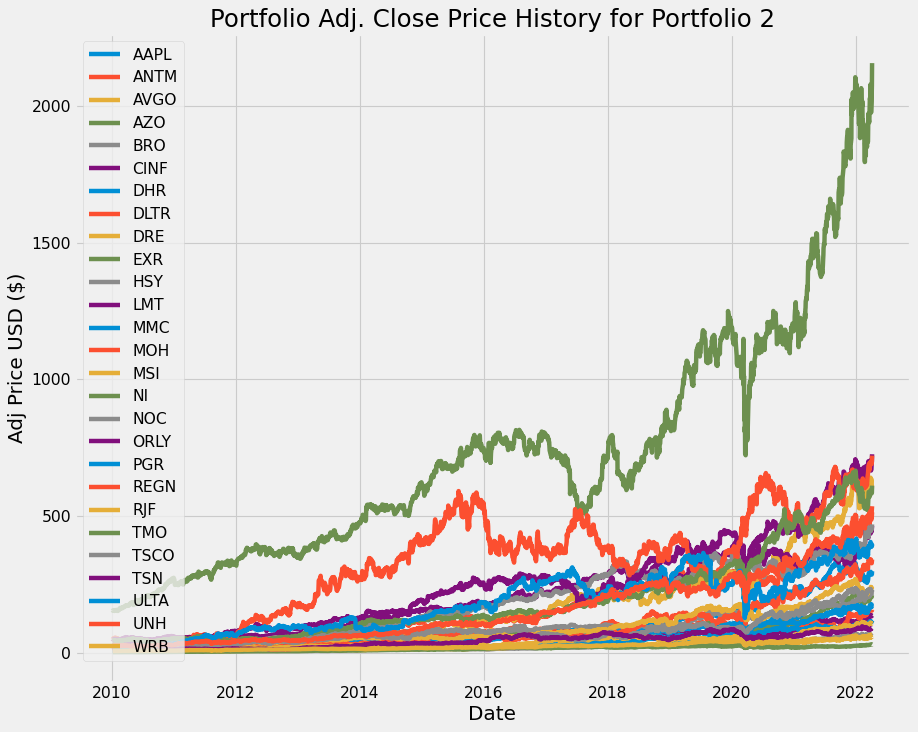

In [10]:
# Visually show the stock Portfolio
title = 'Portfolio Adj. Close Price History for Portfolio 2'

# Get the tickers for our Portfolio
my_stocks = final_df['Tickers']

# Create and plot the graph
plt.figure(figsize=(12, 10), dpi=80)
for ticker in my_stocks:
    df1 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    plt.plot(df1['Adj Close'], label = ticker)

plt.title(title, fontsize = 22)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj Price USD ($)', fontsize = 18)
plt.legend(my_stocks, loc = 'upper left')
plt.savefig('figures/portfolio_2.png')
plt.savefig('figures/portfolio_2.pdf')
plt.show()

# Calculating Returns

In [11]:
# show the daily simple returns
portfolio = pd.DataFrame()
portfolio_returns = pd.DataFrame()
for ticker in my_stocks:
    df2 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    portfolio[ticker] = df2['Adj Close']
    portfolio_returns[ticker] = df2['Adj Close'].pct_change().dropna()
portfolio_returns.head()

,AAPL,ANTM,AVGO,AZO,BRO,...,TSCO,TSN,ULTA,UNH,WRB
Date,,,,,,,,,,,
2010-01-06,-0.015906,0.016225,0.007895,-0.009380,-0.008949,...,-0.002084,0.050521,0.024520,0.009847,0.002048
2010-01-07,-0.001849,0.037145,-0.006266,0.013270,0.000564,...,0.013670,0.017557,0.085328,0.038377,0.004087
2010-01-08,0.006649,0.004398,0.007357,-0.012842,-0.005076,...,-0.000562,-0.002251,0.035954,-0.009391,-0.000814
2010-01-11,-0.008822,0.005787,0.006260,0.001288,0.003968,...,-0.008058,-0.013534,-0.015271,0.006728,0.002037
2010-01-12,-0.011375,-0.013217,-0.015034,-0.002187,0.001129,...,0.000378,-0.011433,-0.006579,-0.026428,0.004065


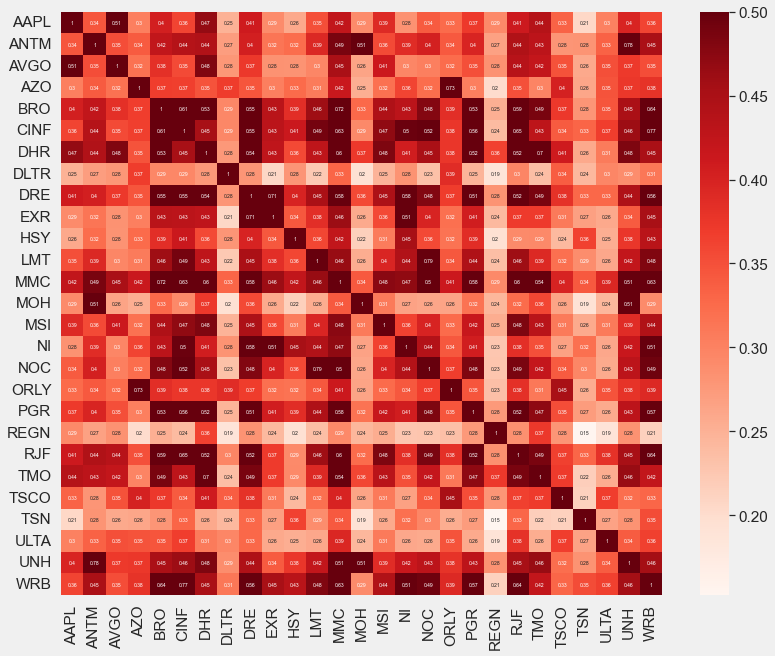

In [12]:
# Making a heat map representing the correlation matrix
plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.4)
sns.heatmap(portfolio_returns.corr(), cmap = "Reds", annot = True, annot_kws = {"size": 5}, vmax = 0.5)
plt.savefig('figures/portfolio_2_hm.png')
plt.savefig('figures/portfolio_2_hm.pdf')
plt.show()

In [13]:
# Create and show the annualized covariance matrix
cov_matrix_annual = portfolio_returns.cov() * 252
cov_matrix_annual

,AAPL,ANTM,AVGO,AZO,BRO,...,TSCO,TSN,ULTA,UNH,WRB
AAPL,0.078928,0.027782,0.050442,0.019849,0.024135,...,0.027182,0.016629,0.033696,0.028652,0.022009
ANTM,0.027782,0.082431,0.035839,0.022697,0.025882,...,0.023293,0.023173,0.038165,0.057396,0.027920
AVGO,0.050442,0.035839,0.125022,0.026087,0.028723,...,0.035836,0.026333,0.049431,0.033697,0.027044
AZO,0.019849,0.022697,0.026087,0.053870,0.018115,...,0.027125,0.017466,0.032024,0.022279,0.019138
BRO,0.024135,0.025882,0.028723,0.018115,0.045210,...,0.023049,0.017088,0.029252,0.024447,0.029453
CINF,0.025722,0.031975,0.031828,0.021572,0.032977,...,0.025116,0.024153,0.037068,0.030028,0.042122
DHR,0.028699,0.027672,0.037142,0.017567,0.024588,...,0.025953,0.016263,0.026673,0.027020,0.021320
DLTR,0.020611,0.022937,0.028889,0.025232,0.018443,...,0.028904,0.020514,0.034583,0.021820,0.019917
DRE,0.030310,0.030535,0.034748,0.021152,0.030722,...,0.029167,0.024757,0.034324,0.029956,0.032085
EXR,0.020287,0.022496,0.024890,0.017552,0.022869,...,0.022310,0.019222,0.025662,0.021717,0.024354


In [14]:
# Calculate the portfolio variance
# weights = np.full((1, 30), 0.033)
weights = np.empty(len(final_df)); weights.fill(1/len(final_df))
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.027777233099490053

In [15]:
# Calculate portfolio Volatility aka Standard Deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.1666650326237932

In [16]:
# Calculate annual portfolio returns
port_simple_annual_return = np.sum(portfolio_returns.mean() * weights) * 252
port_simple_annual_return

0.2479706527762588

In [17]:
# Show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_volatility = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(port_simple_annual_return, 2) * 100) + '%'

print('Expected annual return: '+ percent_ret)
print('Annual Volatility / Risk: '+ percent_volatility)
print('Annual Variance: '+ percent_var)

Expected annual return: 25.0%
Annual Volatility / Risk: 17.0%
Annual Variance: 3.0%


# Portfolio Optimization

In [18]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [19]:
# Portfolio Optimization

# Calculate the expected returns and the annualized samplecovariance matrix of asset returns
mu = expected_returns.mean_historical_return(portfolio)
S = risk_models.sample_cov(portfolio)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('AAPL', 0.13491), ('ANTM', 0.0), ('AVGO', 0.07073), ('AZO', 0.09038), ('BRO', 0.0), ('CINF', 0.0), ('DHR', 0.0), ('DLTR', 0.00203), ('DRE', 0.0), ('EXR', 0.28298), ('HSY', 0.07168), ('LMT', 0.0), ('MMC', 0.0), ('MOH', 0.0), ('MSI', 0.0), ('NI', 0.0), ('NOC', 0.04379), ('ORLY', 0.07341), ('PGR', 0.00068), ('REGN', 0.05302), ('RJF', 0.0), ('TMO', 0.0), ('TSCO', 0.05866), ('TSN', 0.00423), ('ULTA', 0.0), ('UNH', 0.11351), ('WRB', 0.0)])
Expected annual return: 28.4%
Annual volatility: 17.3%
Sharpe Ratio: 1.53


(0.2844639669101383, 0.1726247703024758, 1.5320163290977327)

In [20]:
# Get discrete allocation of each share per stock
# need to install this package by running the command through terminal            conda install -c conda-forge cvxopt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: '+ str(allocation))
print('Funds Remaining: ${:.2f}'.format(leftover))

Discrete Allocation: {'AAPL': 11, 'AVGO': 2, 'AZO': 1, 'EXR': 20, 'HSY': 4, 'NI': 1, 'NOC': 1, 'ORLY': 1, 'REGN': 1, 'TSCO': 4, 'TSN': 1, 'UNH': 3}
Funds Remaining: $9.01


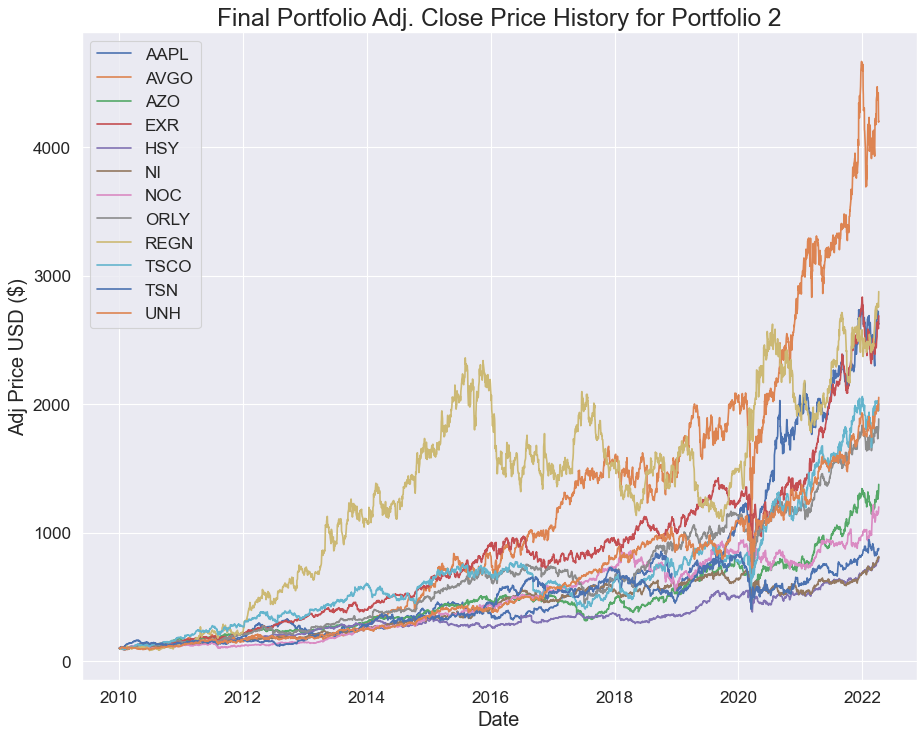

In [21]:
# Visually show the stock Portfolio
title = 'Final Portfolio Adj. Close Price History for Portfolio 2'

# Get the tickers for our Portfolio
stocks_to_invest = list()
for i in allocation.keys():
    stocks_to_invest.append(i)
stocks_to_invest

# Create and plot the graph
plt.figure(figsize=(12, 10), dpi=80)
for ticker in stocks_to_invest:
    df1 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    plt.plot(df1['Normalized Adj Close'], label = ticker)

plt.title(title, fontsize = 22)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj Price USD ($)', fontsize = 18)
plt.legend(stocks_to_invest, loc = 'upper left')
plt.savefig('figures/portfolio_2_optimized.png')
plt.savefig('figures/portfolio_2_optimized.pdf')
plt.show()

In [22]:
# Saving the Stock Allocation to csv
data_items = allocation.items()
data_list = list(data_items)
stocks_to_invest_with_allocation = pd.DataFrame(data_list, columns = ['Tickers', 'Allocation'])
stocks_to_invest_with_allocation.to_csv('portfolio/portfolio-2-optimized-stock-allocation.csv', index = None)

In [23]:
# show the daily simple returns
final_portfolio = pd.DataFrame()
final_portfolio_returns = pd.DataFrame()
for ticker in stocks_to_invest:
    df3 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    final_portfolio[ticker] = df3['Adj Close']
    final_portfolio_returns[ticker] = df3['Adj Close'].pct_change().dropna()
final_portfolio_returns

,AAPL,AVGO,AZO,EXR,HSY,...,ORLY,REGN,TSCO,TSN,UNH
Date,,,,,,,,,,,
2010-01-06,-0.015906,0.007895,-0.009380,0.003387,-0.008609,...,-0.004409,-0.015139,-0.002084,0.050521,0.009847
2010-01-07,-0.001849,-0.006266,0.013270,-0.007594,-0.009769,...,-0.003126,-0.006068,0.013670,0.017557,0.038377
2010-01-08,0.006649,0.007357,-0.012842,-0.022109,-0.003015,...,-0.008884,-0.008140,-0.000562,-0.002251,-0.009391
2010-01-11,-0.008822,0.006260,0.001288,0.007825,-0.005498,...,0.005273,0.019286,-0.008058,-0.013534,0.006728
2010-01-12,-0.011375,-0.015034,-0.002187,-0.035375,0.043394,...,0.018883,-0.013285,0.000378,-0.011433,-0.026428
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.001718,-0.004288,-0.034271,0.019309,0.009879,...,-0.025593,-0.005140,-0.028538,0.015731,0.005138
2022-04-04,0.023693,0.012552,0.021205,-0.016128,-0.010285,...,0.029097,0.005152,0.004279,-0.013071,-0.005014
2022-04-05,-0.018942,-0.032653,0.012473,-0.003492,0.008729,...,0.005300,-0.009937,-0.013967,0.003784,0.015176


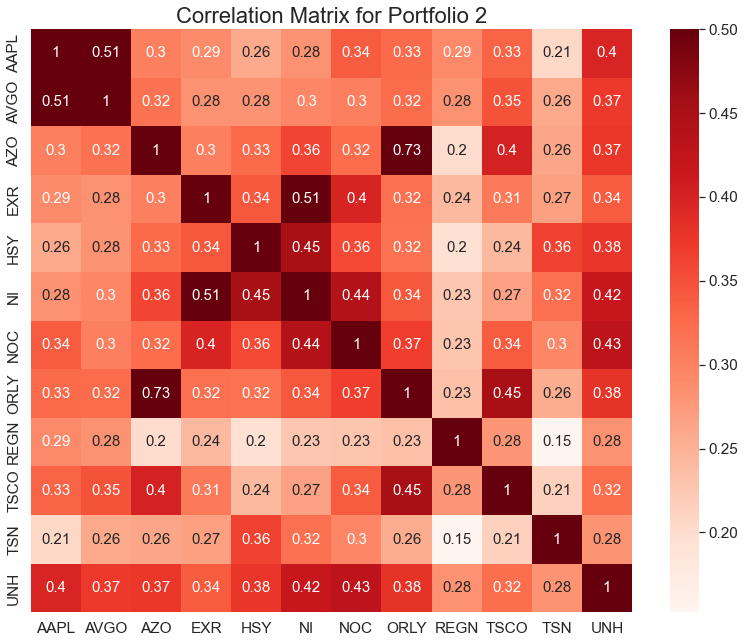

In [24]:
# Making a heat map representing the correlation matrix
title1 = "Correlation Matrix for Portfolio 2"

plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.4)
sns.heatmap(final_portfolio_returns.corr(), cmap = "Reds", annot = True, annot_kws = {"size": 15}, vmax = 0.5)
plt.title(title1, fontsize = 22)
plt.savefig('figures/optimized_portfolio_2_hm.png')
plt.savefig('figures/optimized_portfolio_2_hm.pdf')
plt.show()